# Univariate Analyses with Nilearn

## Setup

In [94]:
!pip install nilearn

### Import packages

In [95]:
import glob
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_glass_brain

### Using openneuro BIDS data
Takes about 10 minutes to complete.

In [96]:
from nilearn.datasets import (
    fetch_ds000030_urls,
    fetch_openneuro_dataset,
    select_from_index,
)

_, urls = fetch_ds000030_urls()

exclusion_patterns = [
    "*group*",
    "*phenotype*",
    "*mriqc*",
    "*parameter_plots*",
    "*physio_plots*",
    "*space-fsaverage*",
    "*space-T1w*",
    "*dwi*",
    "*beh*",
    "*task-bart*",
    "*task-rest*",
    "*task-scap*",
    "*task-task*",
]
urls = select_from_index(
    urls, exclusion_filters=exclusion_patterns, n_subjects=4
)

bids_dir, _ = fetch_openneuro_dataset(urls=urls, verbose=0)

os.chdir(bids_dir)


### Import subject data

In [97]:
subjs_list = pd.read_csv(bids_dir+'/participants.tsv', sep='\t')

subjs_list.head()

,participant_id,diagnosis,age,gender,bart,bht,dwi,pamenc,pamret,rest,scap,stopsignal,T1w,taskswitch,ScannerSerialNumber
0,sub-10159,CONTROL,30,F,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0
1,sub-10171,CONTROL,24,M,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0
2,sub-10189,CONTROL,49,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0
3,sub-10193,CONTROL,40,M,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,35343.0
4,sub-10206,CONTROL,21,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0


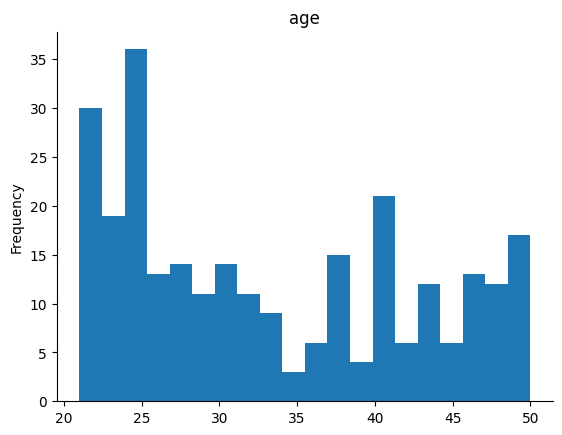

In [98]:
# @title age

from matplotlib import pyplot as plt
subjs_list['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Single Subject Analysis

## Define study and subject variables

In [99]:
task = 'stopsignal'

# Set subj to the first subject in the dataframe
subj = subjs_list.loc[0,'participant_id']

# Define fmriprep template space
template = 'MNI152NLin2009cAsym'

# Define the TR of the functional task
tr = 2

# Set output directory
outp_dir = os.path.join(bids_dir, 'derivatives', task, subj)

In [100]:
# Make participant-specific directory for output if it doesn't exist
if not os.path.exists(outp_dir):
    os.makedirs(outp_dir)

## Find Imaging Data

In [101]:
# Set path to subject specific fmriprep output
fmri_run_data_dir = bids_dir+'/derivatives/fmriprep/'+subj+'/func/'


### Find functional runs

In [102]:
# Find all of the preprocessed functional runs
func_runs = [f for f in glob.glob(fmri_run_data_dir+subj+'_task-'+task+'*space-'+template+'_desc-preproc_bold.nii.gz', recursive=True)]
func_runs.sort()
print('Number of functional runs for '+subj+': '+str(len(func_runs)))

Number of functional runs for sub-10159: 1


### Set a brain mask

In [103]:
# Grab subject's T1 as a mask to keep analysis in subject space
subj_mask = bids_dir+'derivatives/fmriprep/'+subj+'/anat/'+subj+'_space-'+template+'_brainmask.nii.gz'

## Create Design Matrix

### Import the events file

In [104]:
# Find the task event files that are ready to become design matrices
event_files = [f for f in glob.glob(bids_dir+'/'+subj+'/func/'+subj+'_task-'+task+'*_events'+'.tsv', recursive=True)]
event_files.sort()

events = pd.read_csv(event_files[0], sep='\t')
events.fillna('', inplace=True)

events.head()

,onset,duration,trial_type,PresentedStimulusArrowDirection,ReactionTime,SubjectResponseButton,SubjectResponseButtonCode,SubjectResponseCorrectness,TrialOutcome,StopSignalDelay,LadderNumber,LadderTime,LadderMovement,TimeCourse,onset_noTriggerAdjust,TimeCourse_noTriggerAdjust
0,0.006134,1.50,GO,LEFT,0.416274,LEFT,5,CorrectResponse,SuccessfulGo,0.0,0,0,0,0.00,0.006134,0.00
1,0.000000,2.25,,BLANKSCREEN,0.000000,,0,,,0.0,0,0,0,1.50,0.000000,1.50
2,3.762595,1.50,GO,RIGHT,0.395370,RIGHT,28,CorrectResponse,SuccessfulGo,0.0,0,0,0,3.75,3.762595,3.75
3,0.000000,0.75,,BLANKSCREEN,0.000000,,0,,,0.0,0,0,0,5.25,0.000000,5.25
4,6.013056,1.50,GO,LEFT,0.397906,LEFT,5,CorrectResponse,SuccessfulGo,0.0,0,0,0,6.00,6.013056,6.00


### Import motion regressors

In [105]:
confounds = pd.read_csv(fmri_run_data_dir+subj+'_task-'+task+'_desc-confounds_regressors.tsv', sep='\t')

# Replace NaN values with means for the respective variable
confounds.fillna(confounds.mean(), inplace=True)

confounds.head()

,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,tCompCor03,...,aCompCor02,aCompCor03,aCompCor04,aCompCor05,X,Y,Z,RotX,RotY,RotZ
0,-0.899719,2.227516,1.048748,23.691290,0.978043,0.164863,-0.118771,0.113172,-0.032137,0.041810,...,-0.140582,0.018290,-0.106118,0.188625,0.143525,-0.052645,-0.274967,0.001024,0.001434,0.000467
1,-1.246341,0.326954,1.090498,24.634428,1.026863,0.099904,-0.181387,0.036984,0.113388,0.048676,...,0.070998,0.058030,-0.015722,0.111118,0.163622,-0.028109,-0.263217,0.000837,0.002068,0.000516
2,0.366020,-1.068786,1.151430,26.010887,1.027507,0.252018,-0.046286,-0.033369,-0.076722,0.032938,...,-0.031604,-0.052342,-0.031574,-0.061752,0.118415,-0.006555,-0.167094,0.001868,0.001368,0.000464
3,-0.564770,-1.443347,1.106344,24.992373,0.920317,0.122212,-0.043669,-0.053250,-0.036809,-0.024905,...,-0.011359,0.010522,-0.061436,0.018885,0.096408,-0.006393,-0.137269,0.000894,0.000948,0.000454
4,-1.436600,-3.153236,0.914109,20.649788,0.871629,0.014257,-0.074981,-0.079292,0.079099,-0.054966,...,0.079117,0.063985,-0.049137,0.070348,0.102231,-0.006412,-0.136650,0.001024,0.000948,0.000429


## First level analysis for a single subject

### Set the first level model parameters

In [106]:
fmri_glm = FirstLevelModel(t_r=tr,
                            #mask_img=subj_mask,
                            #slice_time_ref=0.5,  # Check to see how your data was preprocessed
                            noise_model='ar1',
                            standardize=False,
                            hrf_model='spm',
                            drift_model='polynomial')

### Conduct the GLM using the functional data, event file, and the confounds

**Exercise:** Conduct the first level GLM

In [ ]:
# Conduct the GLM using the functional data, event file, and the confounds
fmri_glm = fmri_glm.fit(..., ..., ...)
fmri_glm

In [192]:
# @title Click for solution
fmri_glm = fmri_glm.fit(func_runs, events, confounds)
fmri_glm

/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: LadderTime, LadderMovement, onset_noTriggerAdjust, TrialOutcome, SubjectResponseButtonCode, SubjectResponseButton, SubjectResponseCorrectness, PresentedStimulusArrowDirection, LadderNumber, ReactionTime, StopSignalDelay, TimeCourse, TimeCourse_noTriggerAdjust
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


FirstLevelModel(drift_model='polynomial', hrf_model='spm', t_r=2)

### Examine the design matrix

In [184]:
# Specify the design matrix to pull conditions and contrasts later
design_matrix = fmri_glm.design_matrices_[0]

**Exercise:** Plot a heatmap of the design matrix

In [ ]:
sns.heatmap(..., vmin=-1, vmax=1, cmap='Greys')

<Axes: >

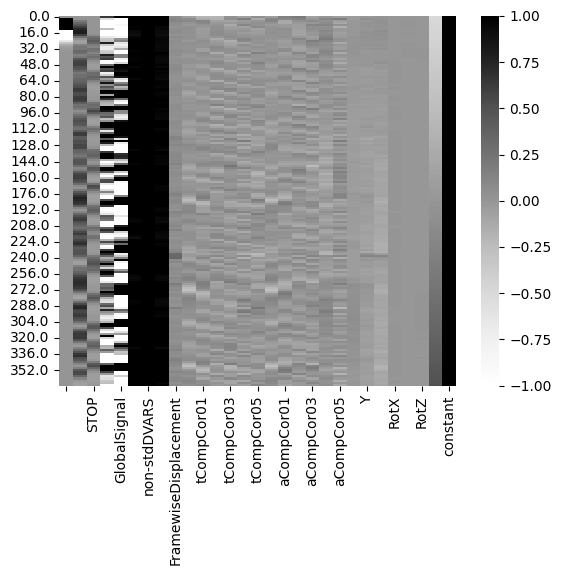

In [190]:
# @title Click for solution

sns.heatmap(design_matrix, vmin=-1, vmax=1, cmap='Greys')

### Contrasts
Set contrasts for each condition, to make a beta map for each condition. This loop sets a column of 1s for each condition separately, so that each condition can be examined separately

In [108]:
design_matrix.columns

Index(['', 'GO', 'STOP', 'WhiteMatter', 'GlobalSignal', 'stdDVARS',
       'non-stdDVARS', 'vx-wisestdDVARS', 'FramewiseDisplacement',
       'tCompCor00', 'tCompCor01', 'tCompCor02', 'tCompCor03', 'tCompCor04',
       'tCompCor05', 'aCompCor00', 'aCompCor01', 'aCompCor02', 'aCompCor03',
       'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ',
       'drift_1', 'constant'],
      dtype='object')

<Axes: >

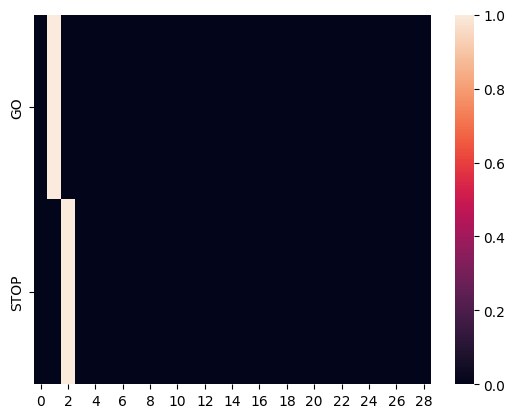

In [109]:
relv_conds=['GO', 'STOP']

# Find the total number of conditions in the design matrix
n_conds = len(design_matrix.columns)

contrasts = {}
for cond in relv_conds:
    contrasts[cond] = np.zeros(n_conds)
    cond_idx = [design_matrix.columns.to_list().index(cond)]
    contrasts[cond][cond_idx] = 1

sns.heatmap(pd.DataFrame(contrasts).T)

In [110]:
# Create z-scored beta maps contrasts
for n_cont in range(len(contrasts)):
    cont_name = list(contrasts.keys())[n_cont]
    z_map = fmri_glm.compute_contrast(contrasts[cont_name], output_type='z_score')

    z_map.to_filename(os.path.join(outp_dir,'zmap_'+task+'_'+cont_name+'.nii.gz'))


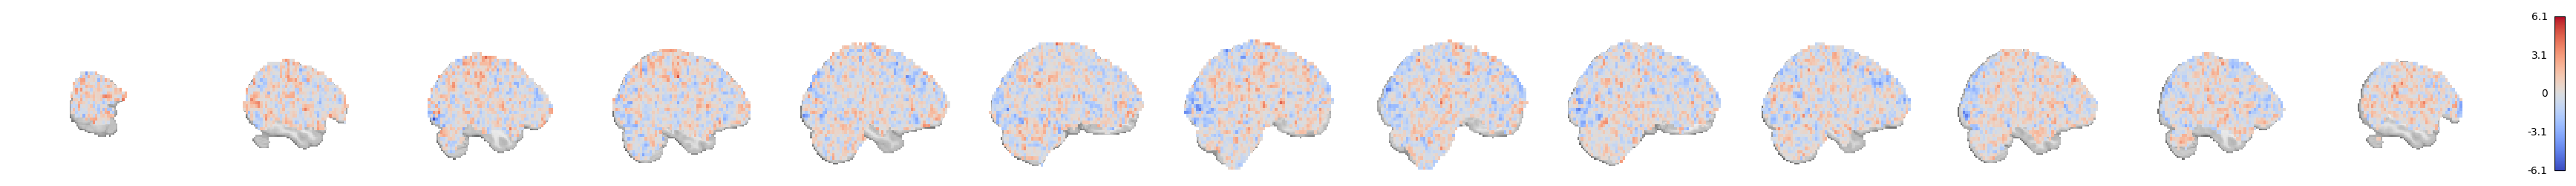

In [111]:
plot_stat_map(z_map,
              cut_coords=range(-65,65, 10), display_mode='x', colorbar=True,
              cmap='coolwarm', symmetric_cbar=True, annotate=False)

## Create Specific Contrasts

In [112]:
# Create a list of conditions that will be tested against each other
# The index of each list will be the contrast (e.g. cond_a_list[0] > cond_b_list[0])
cond_a_list = ['STOP']
cond_b_list = ['GO']
contrasts_df = pd.DataFrame(list(zip(cond_a_list, cond_b_list)),
                            columns=['cond_a','cond_b'])
contrasts_df

,cond_a,cond_b
0,STOP,GO


In [113]:
# Create a dictionary that will store the contrast arrays
contrasts_bw_conds = {}

dm_cols = list(design_matrix.columns)

In [114]:
# Loop through and fill in 1s and 0s for contrasts
for n in range(len(contrasts_df)):
    # Find the condition names to be contrasted
    cond_a = contrasts_df.loc[n,'cond_a']
    cond_b = contrasts_df.loc[n,'cond_b']

    # Create an array of zeros
    contrasts_bw_conds[cond_a+'_V_'+cond_b] = np.zeros(len(dm_cols))

    # Find the index of each condtion as defined before
    temp_idx_a = dm_cols.index(cond_a)
    temp_idx_b = dm_cols.index(cond_b)

    # Fill the exact condition index in the contrast array with a 1 or -1
    contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_a] = 1
    contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_b] = -1

<Axes: >

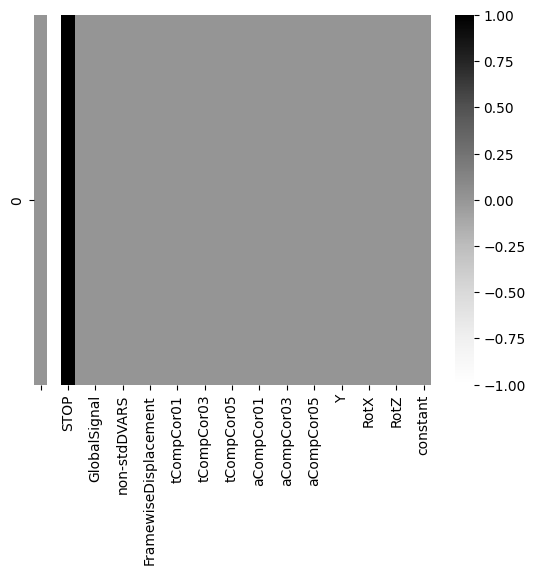

In [116]:
temp_df = pd.DataFrame([contrasts_bw_conds['STOP_V_GO']], columns=dm_cols)


sns.heatmap(temp_df, cmap='Greys')


In [117]:
# Create contrast maps
for n_cont in range(len(contrasts_bw_conds)):
    cont_name = list(contrasts_bw_conds.keys())[n_cont]
    z_map = fmri_glm.compute_contrast(contrasts_bw_conds[cont_name], output_type='z_score')

    z_map.to_filename(os.path.join(outp_dir,'zmap_'+task+'_'+cont_name+'.nii.gz'))



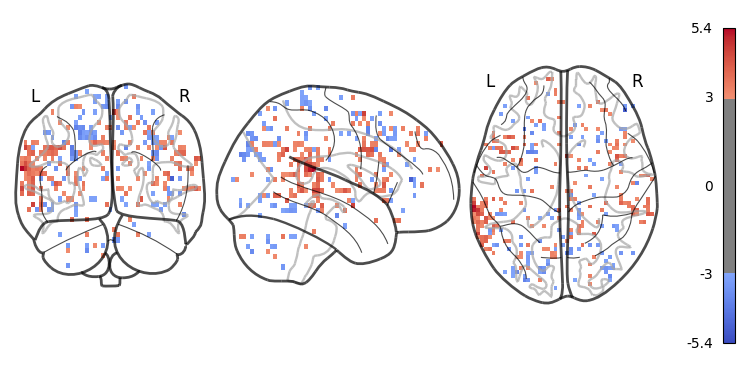

In [118]:
plot_glass_brain(
    z_map,
    threshold=3,
    colorbar=True,
    plot_abs=False,
    display_mode="ortho", cmap='coolwarm'
)

**Exercise:** Use the [plot_stat_map](https://nilearn.github.io/stable/modules/generated/nilearn.plotting.plot_stat_map.html#nilearn.plotting.plot_stat_map) function to plot a sagital view of the whole brain, even 10 slices.

In [ ]:
plot_stat_map(...,
              cut_coords=range(-65,65, ...), display_mode=..., colorbar=True,
              cmap=..., symmetric_cbar=True, annotate=True)

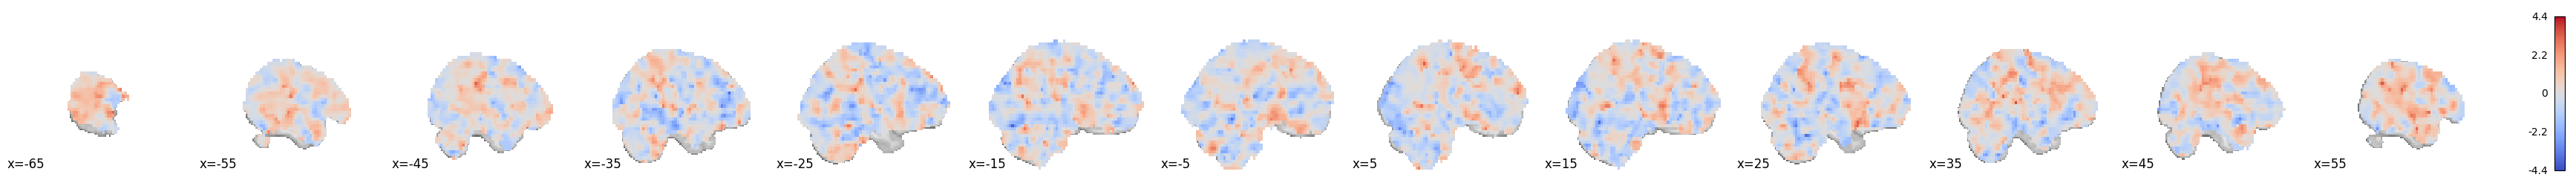

In [193]:
# @title Click for solution
plot_stat_map(z_map,
              cut_coords=range(-65,65, 10), display_mode='x', colorbar=True,
              cmap='coolwarm', symmetric_cbar=True, annotate=True)

In [136]:
for subj in subjs_list['participant_id'][1:5]:

  # Set output directory
  outp_dir = os.path.join(bids_dir, 'derivatives', task, subj)

  # Find all of the preprocessed functional runs
  func_runs = [f for f in glob.glob(bids_dir + '/derivatives/fmriprep/'+subj+'/func/'+subj+'_task-'+task+'*space-'+template+'_desc-preproc_bold.nii.gz', recursive=True)]
  func_runs.sort()
  print('Number of functional runs for '+subj+': '+str(len(func_runs)))

  if len(func_runs) == 0:
    continue


  # Grab subject's T1 as a mask to keep analysis in subject space
  #subj_mask = bids_dir+'derivatives/fmriprep/'+subj+'/anat/'+subj+'_space-'+template+'_label-GM_probseg_bin.nii.gz'

  # Find the task event files that are ready to become design matrices
  event_files = [f for f in glob.glob(bids_dir + '/derivatives/task_socialreward/data/SCN_'+subj[-3:]+'/'+subj+'_task-'+task+'_run-*_desc-events'+'.csv', recursive=True)]
  event_files.sort()

  # Set path to subject specific fmriprep output
  fmri_run_data_dir = bids_dir+'/derivatives/fmriprep/'+subj+'/func/'

  # Find confound regressors
  confounds = pd.read_csv(fmri_run_data_dir+subj+'_task-'+task+'_desc-confounds_regressors.tsv', sep='\t')

  # Replace NaN values with means for the respective variable
  confounds.fillna(confounds.mean(), inplace=True)

  fmri_glm = FirstLevelModel(t_r=tr,
                            #mask_img=subj_mask,
                            #slice_time_ref=0.5,  # Check to see how your data was preprocessed
                            noise_model='ar1',
                            standardize=False,
                            hrf_model='spm',
                            drift_model='polynomial')




  # Conduct the GLM using the functional data, event file, and the confounds
  fmri_glm = fmri_glm.fit(func_runs, events, confounds)

  # Specify the design matrix to pull conditions and contrasts later
  design_matrix = fmri_glm.design_matrices_[0]

  # Find the total number of conditions in the design matrix
  n_conds = len(design_matrix.columns)


  # Set contrasts for each condition, to make a beta map for each condition
  # This loop sets a column of 1s for each condition separately, so that
  # each condition can be examined separately
  contrasts = {}
  for cond in relv_conds:
    contrasts[cond] = np.zeros(n_conds)
    cond_idx = [design_matrix.columns.to_list().index(cond)]
    contrasts[cond][cond_idx] = 1


  # Make participant-specific directory for output if it doesn't exist
  if not os.path.exists(outp_dir):
    os.makedirs(outp_dir)

  # Create z-scored beta maps contrasts
  for n_cont in range(len(contrasts)):
    cont_name = list(contrasts.keys())[n_cont]
    z_map = fmri_glm.compute_contrast(contrasts[cont_name], output_type='z_score')

    z_map.to_filename(os.path.join(outp_dir,'zmap_'+task+'_'+cont_name+'.nii.gz'))



  # Create specific contrasts

  # Create a dictionary that will store the contrast arrays
  contrasts_bw_conds = {}

  dm_cols = list(design_matrix.columns)

  # Loop through and fill in 1s and 0s for contrasts
  for n in range(len(contrasts_df)):
      # Find the condition names to be contrasted
      cond_a = contrasts_df.loc[n,'cond_a']
      cond_b = contrasts_df.loc[n,'cond_b']

      # Create an array of zeros
      contrasts_bw_conds[cond_a+'_V_'+cond_b] = np.zeros(len(dm_cols))

      # Find the index of each condtion as defined before
      temp_idx_a = dm_cols.index(cond_a)
      temp_idx_b = dm_cols.index(cond_b)

      # Fill the exact condition index in the contrast array with a 1 or -1
      contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_a] = 1
      contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_b] = -1


  # Create contrast maps
  for n_cont in range(len(contrasts_bw_conds)):
      cont_name = list(contrasts_bw_conds.keys())[n_cont]
      z_map = fmri_glm.compute_contrast(contrasts_bw_conds[cont_name], output_type='z_score')

      z_map.to_filename(os.path.join(outp_dir,'zmap_'+task+'_'+cont_name+'.nii.gz'))

Number of functional runs for sub-10171: 1


/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: LadderTime, LadderMovement, onset_noTriggerAdjust, TrialOutcome, SubjectResponseButtonCode, SubjectResponseButton, SubjectResponseCorrectness, PresentedStimulusArrowDirection, LadderNumber, ReactionTime, StopSignalDelay, TimeCourse, TimeCourse_noTriggerAdjust
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


Number of functional runs for sub-10189: 1


/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: LadderTime, LadderMovement, onset_noTriggerAdjust, TrialOutcome, SubjectResponseButtonCode, SubjectResponseButton, SubjectResponseCorrectness, PresentedStimulusArrowDirection, LadderNumber, ReactionTime, StopSignalDelay, TimeCourse, TimeCourse_noTriggerAdjust
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


Number of functional runs for sub-10193: 0
Number of functional runs for sub-10206: 1


/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: LadderTime, LadderMovement, onset_noTriggerAdjust, TrialOutcome, SubjectResponseButtonCode, SubjectResponseButton, SubjectResponseCorrectness, PresentedStimulusArrowDirection, LadderNumber, ReactionTime, StopSignalDelay, TimeCourse, TimeCourse_noTriggerAdjust
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


# Second Level Analysis

## Set Up

### Import packages

In [121]:
import os
import glob
import pandas as pd
import numpy as np

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img, cluster_level_inference

### Set up directories

In [142]:
# Set output directory
outp_dir = os.path.join(bids_dir, 'derivatives', task, 'group')

# Make participant-specific directory for output if it doesn't exist
if not os.path.exists(outp_dir):
  os.makedirs(outp_dir)

## Create Design Matrix

<Axes: label='conditions', ylabel='scan number'>

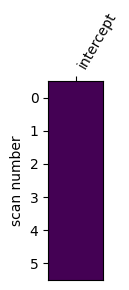

In [122]:
design_matrix = make_second_level_design_matrix(subjs_list.loc[:5,'participant_id'])

plot_design_matrix(design_matrix)

## Conduct Second Level Analyses

In [174]:
contrasts=['GO','STOP_V_GO']
alpha = 0.05
mc = 'fdr'

data_dir = bids_dir+'/derivatives/stopsignal/'

threshold_data = {}

for contrast in contrasts:
      subjs_list_fl = list(subjs_list.loc[:5, 'participant_id'].copy())
      temp_file_list = []
      for subj in subjs_list.loc[:5, 'participant_id']:
          temp_file = glob.glob(os.path.join(data_dir,subj,
                                             'zmap_'+task+'_'+contrast+'.nii.gz'))
          if len(temp_file) == 0:
              subjs_list_fl.remove(subj)
              continue
          temp_file_list.append(temp_file[0])
      temp_file_list.sort()

      print('Calculating group '+contrast+' contrast for '+str(len(temp_file_list))+' subjects')

      design_matrix = make_second_level_design_matrix(subjs_list_fl)
      model = SecondLevelModel(#mask_img=mni_mask,
                               smoothing_fwhm=8.0)
      model.fit(temp_file_list, design_matrix=design_matrix)

      contrast_stats = model.compute_contrast(output_type='all')
      z_map = contrast_stats['z_score']
      e_map = contrast_stats['effect_size']

      z_map.to_filename(os.path.join(data_dir, 'group',
                                 task+'_'+contrast+'_zmap.nii.gz'))
      e_map.to_filename(os.path.join(data_dir, 'group',
                                 task+'_'+contrast+'_effect.nii.gz'))

      # Multiple Comparisons Correction
      z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
      #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
      z_map_thresh.to_filename(os.path.join(data_dir, 'group',
                                 task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
      #z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
      #                           'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))

      threshold_data[task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)] = threshold

Calculating group GO contrast for 4 subjects
Calculating group STOP_V_GO contrast for 4 subjects


/usr/local/lib/python3.10/dist-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 4.356046508076697. But, you have given threshold=inf.
  stat_img = threshold_img(


## Visualize Results

In [175]:
# @title Transparent plotting function
from matplotlib.gridspec import GridSpec

import matplotlib.pyplot as plt

from nilearn.plotting import plot_stat_map

def plot_transparent_threshold(filename, thresh=1, mc='fdr', mc_alpha=0.05, view='split', title=''):
    # Find stat map
    stat_filename = os.path.join(filename+'_effect.nii.gz')
    stat_filename_mc = os.path.join(filename+'_zmap_'+mc+'-'+str(mc_alpha)+'.nii.gz')



    if view == 'split':
        # Set figure specs
        fig = plt.figure(figsize=(15, 6))
        gs = GridSpec(4, 2)

        # Plot whole brain maps
        ax_img1 = plt.subplot(gs[0, :])
        ax_img2 = plt.subplot(gs[1, :])

        hemi_lh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img1,
                                cut_coords=range(-65,0, 10), display_mode='x', colorbar=True,
                                cmap='coolwarm', symmetric_cbar=True, title='Left Hemisphere',
                                annotate=False)
        hemi_rh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img2,
                                cut_coords=range(66,5, -10), display_mode='x', colorbar=True,
                                cmap='coolwarm', symmetric_cbar=True, title='Right Hemisphere',
                                annotate=False)
        hemi_lh.add_contours(stat_filename_mc, levels=[-mc_alpha,mc_alpha], colors=['blue','red'],
                          alpha=1, linewidths=1)
        hemi_rh.add_contours(stat_filename_mc, levels=[-mc_alpha,mc_alpha], colors=['blue','red'],
                          alpha=1, linewidths=1)


        # Plot ventral striatum ROI
        ax_img3 = plt.subplot(gs[2:, 1])

        roi_map = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img3,
                                cut_coords=[8], display_mode='y', colorbar=False,
                                cmap='coolwarm', symmetric_cbar=True,
                                annotate=True)
        roi_map.add_contours(stat_filename_mc, levels=[-mc_alpha,mc_alpha], colors=['blue','red'],
                          alpha=1, linewidths=1)



/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_slicers.py:361: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)


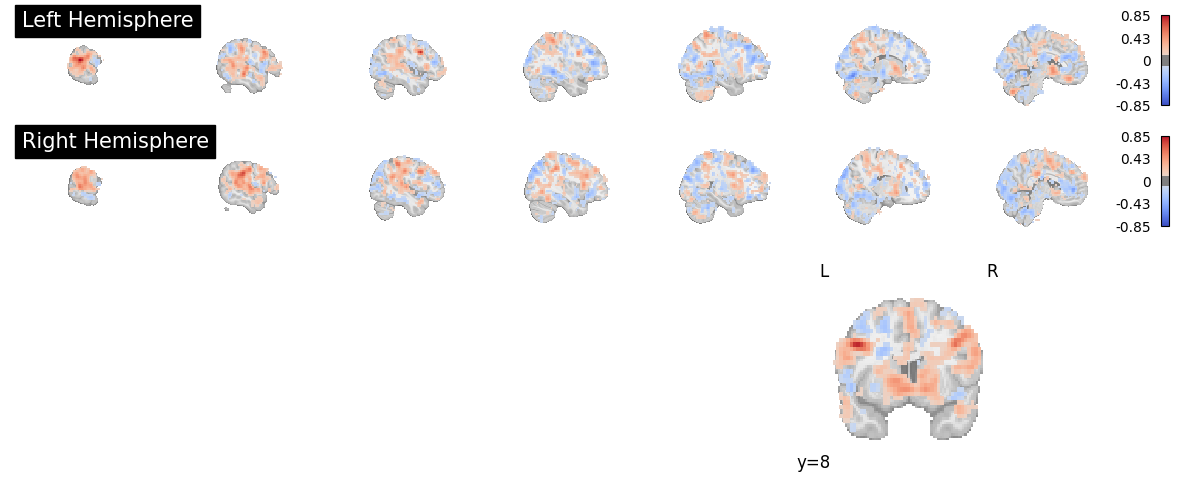

In [180]:
# Set path of the analysis to plot
# Dont include the file suffixes ("_effect", "_zmap") and extensions (.nii.gz)
filename = data_dir+'/group/'+'stopsignal_STOP_V_GO'

plot_transparent_threshold(filename, thresh=.1, mc_alpha=0.05)